# DS 3000 - Assignment 10

**Student Name**: Ala'a Tamam
**Date**: 11/12/2023


### Submission Instructions
Submit this `ipynb` file to canvas.

The `ipynb` format stores outputs from the last time you ran the notebook.  (When you open a notebook it has the figures and outputs of the last time you ran it too).  To ensure that your submitted `ipynb` file represents your latest code, make sure to give a fresh run `Kernel > Restart & Run All` just before uploading the `ipynb` file to Canvas.

### Academic Integrity

**Writing your homework is an individual effort.**  You may discuss general python problems with other students but under no circumstances should you observe another student's code which was written for this assignment, from this year or past years.  Pop into office hours or DM us in MS Teams if you have a specific question about your work or if you would like another pair of eyes or talk through your code.

Don't forget to cite websites which helped you solve a problem in a unique way.  You can do this in markdown near the code or with a simple one-line comment. You do not need to cite the official python documentation.

**Documentation / style counts for credit**  Please refer to the Pep-8 style, to improve the readability and consistency of your Python code. For more information, read the following article [How to Write Beautiful Python Code With PEP 8](https://realpython.com/python-pep8/) or ask your TA's for tips.

**NOTE:<span style='color:red'> Write python expressions to answer ALL questions below and ensure that you use the `print()` function to display the output.</span>** Each question should be answered in a new code cell. For example, your solution for question 1.1 should be in a different code cell from your solution for question 1.2.

Overall question:
In this assignment, you will build a machine learning model to predict tip amount using the NYC Green Taxi Trip Records data for February 2020. Here is a link to the accompanying data dictionary. Ensure that you explain each step and the results from each question. You are encouraged to include your previous data preparation steps from Assignment 4 as needed.

Data Source: https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2020-02.parquet

In this assignment, you will use the random forest algorithm to build a machine learning model that predicts the tip_amount. You will be working with a dataset that you are familiar with, and you will learn how to use the insights from EDA to guide your modeling decisions.

Write python code to answer the questions below and ensure that you round the result of all numeric calculations to 2 decimal places. 



## Question 1: 

load the data directly from the URL into a DataFrame.

( 10 pts) Include any previous data preparation steps, EDA and visualizations. It is ok to reuse your previous code from assignment 4. However, ensure that you update the code based on the previous feedback from the TAs. 

Also, address the following:
Ensure that you delete any widespread missing data and handle negative dollar amounts. Justify your approach to handling negative amounts.
The findings from your previous analysis would have indicated that most customers use green taxis to travel short distances. Therefore, ensure that you filter any outlier trips.

In [1]:
#install paraquet 
!pip install fastparquet
import pandas as pd 

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error

In [2]:
tripdata_df = pd.read_parquet(path = 'https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2020-02.parquet',
                      engine = 'fastparquet')

In [3]:
# first data prep step -> inspect the data 
# in HW4 i got three points off for only taking rows from the head
# so in this one make sure to look into shape function 

dimensions = tripdata_df.shape
print("dimensions", dimensions)

data_types = tripdata_df.dtypes
print("variable types\n:", data_types)

dimensions (398632, 20)
variable types
: VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                       float64
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object


In [4]:
# updating my data cleaning to account for feedback from hw 4
# first -> there were incorrect data types so this
tripdata_df['PULocationID'] = tripdata_df['PULocationID'].astype('int')
tripdata_df['DOLocationID'] = tripdata_df['DOLocationID'].astype('int')

# second -> dealing with nulls
tripdata_df.fillna({'some_column': 'default_value'}, inplace=True) 

# third -> getting rid of duplicates
tripdata_df.drop_duplicates(inplace=True)

# Handling negative values
columns_to_check = ['trip_distance', 'fare_amount', 'passenger_count']
for col in columns_to_check:
    tripdata_df = tripdata_df[tripdata_df[col] >= 0]

# also if the passenger count is non-int
def isWholeNumber(value):
    try:
        int_value = int(value)
        return int_value == value 
    except ValueError:
        return False  


tripdata_df = tripdata_df[tripdata_df['passenger_count'].apply(isWholeNumber)]

#dealing with outliers:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

tripdata_df = remove_outliers(tripdata_df, 'trip_distance')
tripdata_df = remove_outliers(tripdata_df, 'fare_amount')

# also lets reflect the percentage of data that is missing
missing_percentage = (tripdata_df.isnull().sum() / len(tripdata_df)) * 100

print("the updateed df shape:", tripdata_df.shape)
print("Missing data percent:\n", missing_percentage)


the updateed df shape: (281743, 20)
Missing data percent:
 VendorID                   0.0
lpep_pickup_datetime       0.0
lpep_dropoff_datetime      0.0
store_and_fwd_flag         0.0
RatecodeID                 0.0
PULocationID               0.0
DOLocationID               0.0
passenger_count            0.0
trip_distance              0.0
fare_amount                0.0
extra                      0.0
mta_tax                    0.0
tip_amount                 0.0
tolls_amount               0.0
ehail_fee                100.0
improvement_surcharge      0.0
total_amount               0.0
payment_type               0.0
trip_type                  0.0
congestion_surcharge       0.0
dtype: float64


justify your approach to handling negative outputs:

I used a for loop to check for amounts that were less than or equal to zero inside  three variables/columns  which are: trip_distance', 'fare_amount', 'passenger_count'. My approach is good in terms of time performance, and through the creation of a for-loop I can iterate with good coverage. 

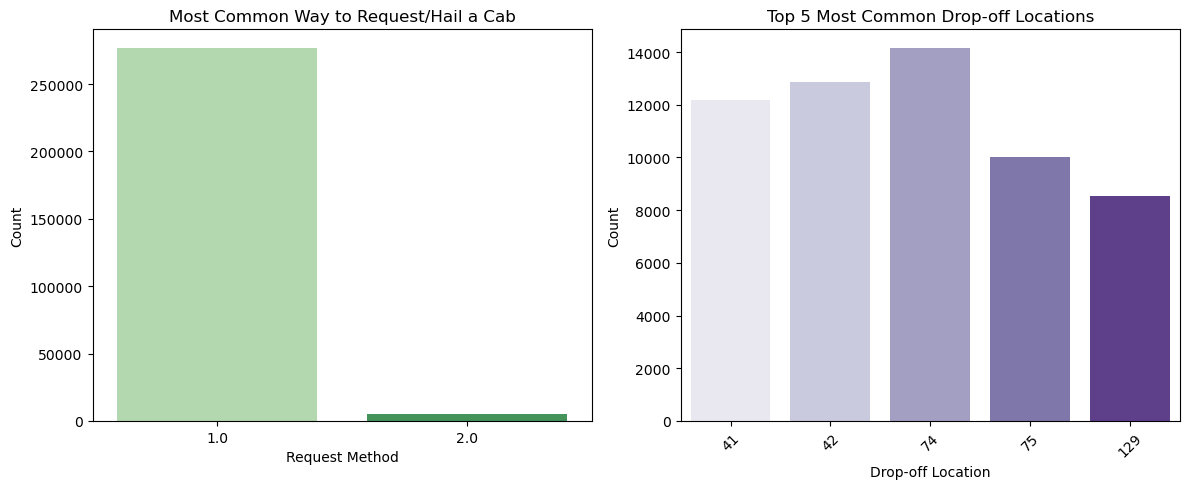

In [5]:
## data visualizaton (from my hw4)
import matplotlib.pyplot as plt  
import seaborn as sns


most_common_request_method = tripdata_df['trip_type'].mode()[0]

top_dropoff_locations = tripdata_df['DOLocationID'].value_counts().nlargest(5)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(data=tripdata_df, x='trip_type', palette='Greens')
plt.title('Most Common Way to Request/Hail a Cab')
plt.xlabel('Request Method')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.barplot(x=top_dropoff_locations.index, y=top_dropoff_locations.values, palette='Purples')
plt.title('Top 5 Most Common Drop-off Locations')
plt.xlabel('Drop-off Location')
plt.ylabel('Count')
plt.xticks(rotation=45) 

plt.tight_layout()
plt.show()

## Question 2: 
(5 pts) Based on the insights from your EDA, select the required features to build your model and ensure that you encode any categorical variables. Briefly explain the reason for the features that you selected. 
Remember that Data Science relies heavily on experimentation. Therefore, you are encouraged to experiment with your data.
Tip #1: ensure that you carefully consider each feature. For example, the total_amount is a variable in your dataframe; however the total amount for each trip can also be obtained if you add all the charges for each passenger (e.g. fare_amount + extra + mta_tax + tip_amount + tolls_amount + improvement_surcharge + congestion_surcharge). Therefore, is it best to include the total_amount in your model or the breakdown that shows each individual charge? Think about the pros and cons of your decisions.
Tip #2: you are predicting the tip amount, therefore it should not be one of your explanatory variables.

Since the goal is to ultimately predict the tip amount I dont think it should be included as a feature.

Advantages and disadvantages of using total_amount versus the variables that add up to total amount:

- disadvantages:
    - consolidates information too much, might limit the ability of the model to make highly informed prediction. Using multiple variables gives the model more to pull from. Like in the lecture videos where the prof was creating a model to predict if a student liked a class, by having many different types of variables she was able to create a more hollisitc model.
        - basically might misconstrue what what is a key factor in a 
          high/low tip amount. 
- advantages:
    - simplifies the model by reducing the # of features
        - more model complexity could lead to overfitting, which we 
           can fix but is not ideal. 

Overall answer: 
I am going to use pickup_hour, pickup_day_of_the_week because those two could be helpful in predicting based on the time and day of the week (rush hour). As well as trip_distance because if a trip is long the person might be inclined to tip better. The PULocationID and the DOLocationID because there might be some really indemand areas where the driver is more likely to get a tip due to limited availability. So maybe college campuses, next to train stations, airports, things of that nature. And lastly the trip charges: fare_amount, extra, mta_tax, tolls_amount, while less immediately impactive they might provide insight on how the cost elements influence tipping. 

feature encoding (thinkin abt it here doing it in the next cell):
categorical encoding -> PULocationID, DOLocationID, pickup_hour, pickup_day_of_week

continuous variables -> trip_distance and fare_amount, extra, mta_tax, tolls_amount 

In [6]:
import pandas as pd

tripdata_df['pickup_hour'] = tripdata_df['lpep_pickup_datetime'].dt.hour
tripdata_df['pickup_day_of_week'] = tripdata_df['lpep_pickup_datetime'].dt.dayofweek

features = ['pickup_hour', 'pickup_day_of_week', 'trip_distance', 
            'fare_amount', 'extra', 'mta_tax', 'tolls_amount', 
            'PULocationID', 'DOLocationID']
X = tripdata_df[features]

y = tripdata_df['tip_amount'] # target variable! What we are trying to predict


## Question 3
(5 pts) Partition the prepared data into train/test sets and ensure that your partitions are reproducible.

In [7]:
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, # allocate 20 percent of data to testing
                                                       random_state=7) # was seed in lab, so keeping this
    

## Question 4
(10 pts) Using the Random Forest algorithm, build a machine learning model that predicts the tip amount. 
Think about the following: Are you performing classification or regression? Ensure that you choose the appropriate Random Forest Classifier/Regressor from scikit-learn. 


In [8]:
randomforest_regressor = RandomForestRegressor(random_state=7) #what was in the lab, so lets keep this

randomforest_regressor.fit(X_train, y_train) # train the model x and y

y_pred = randomforest_regressor.predict(X_test) # predict

print("Predictions:", y_pred) ## and print! slay


Predictions: [0.5458 0.8527 1.7017 ... 1.6117 0.8283 0.6421]


## Question 5
(5 pts) Evaluate the predictions from your model and comment on the results. Ensure that you choose the appropriate metric to evaluate the model and round your calculations to two decimal places. Remember that we evaluate models differently depending on the task, i.e. classification or regression.

In [9]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)

print(f"the mean squared error (mse) is equal to: {mse:.2f}")

# lower mse is ideal


the mean squared error (mse) is equal to: 5.60


## Question 6
(15 pts) What are your thoughts on the model's prediction capability? Did it do a good job of predicting the tip_amount? 
Note: it is okay if your first version of the model is not the best. However, there are strategies that we can use to improve it, such as tuning.
Tune the model: you can control the number of trees in your forest using the n_estimators parameter. Refer to the sample code from the lecture and also view the documentation** Links to an external site. to learn more about this algorithm and its parameters. Try at least three different values for the n_estimators parameter to determine if the model improved. Show all your steps to create, evaluate and tune each version of the model.
Indicate which model performed the best.

The models prediction capability was an ok attempt but there was definitely room for improvement. Mostly in terms of the runtime, which is something that we dont cover explictly in this course. 

the best/lowest mean squared error however resulted from an n_estimator amount of 10, which resulted in a mse of 5.31. 

In [10]:
from sklearn.metrics import mean_squared_error, r2_score

best_mse = float('inf')
best_rf_model = None
best_nestim = 0
estimators = [10, 50, 100, 400] ## using these estims to tune


for n in estimators:
    ## here I am creating a new model based on my given n_estimator
    model = RandomForestRegressor(n_estimators=n, random_state=7) # this was seed in lab so leaving it
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    

    if mse < best_mse:
        best_mse = mse
        best_rf_model = model
        best_nestim = n

    # print(best_mse) -> 5.31 commenting it out so it doesnt keep printing with every run
    print(f"Model with {n} estimators")
    print(f"MSE: {mse:.2f}, R-squared: {r2:.2f}\n")
    

    

Model with 10 estimators
MSE: 5.31, R-squared: -0.57

Model with 50 estimators
MSE: 6.27, R-squared: -0.85

Model with 100 estimators
MSE: 5.60, R-squared: -0.65

Model with 400 estimators
MSE: 5.45, R-squared: -0.61



## Question 7
(+5 bonus points) The Random forest has a method that returns the importance of each feature in your model. Review the documentation to learn about feature importance. After which, write the appropriate code that demonstrates which features were the most important when making the predictions. Demonstrate the feature importance using the best model and explain the results.

              Feature  Importance
2       trip_distance    0.238021
0         pickup_hour    0.185333
8        DOLocationID    0.168451
3         fare_amount    0.153889
7        PULocationID    0.132810
1  pickup_day_of_week    0.097441
4               extra    0.018259
5             mta_tax    0.003158
6        tolls_amount    0.002639


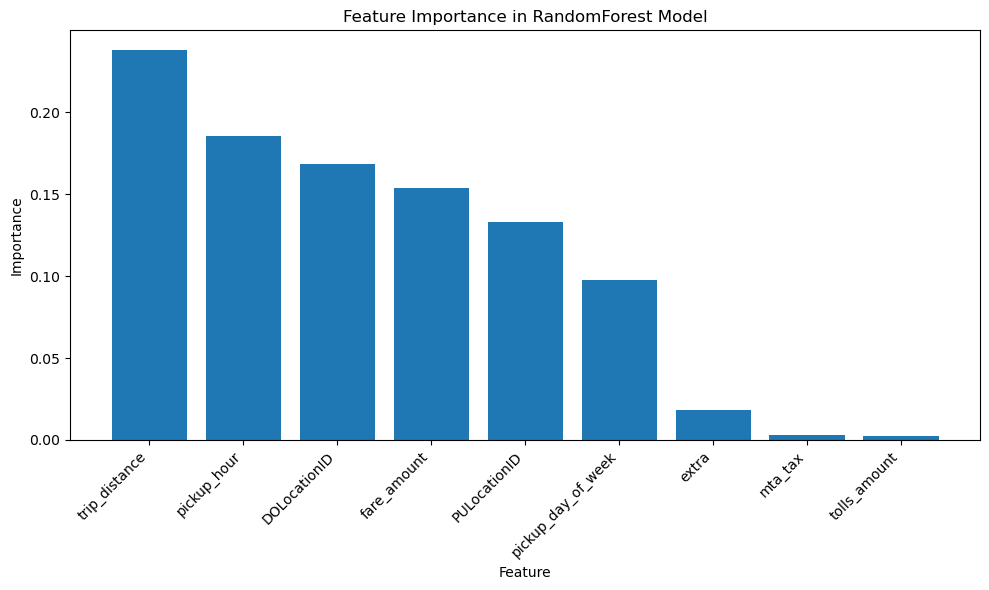

In [11]:
## this for sure is not fully working, but its what I have right now.....

importances = best_rf_model.feature_importances_

ftr_names = X_train.columns

feature_importances = pd.DataFrame({'Feature': ftr_names, 'Importance': importances})

feature_importances_sorted = feature_importances.sort_values(by='Importance', ascending=False)

print(feature_importances_sorted)

plt.figure(figsize=(10, 6))
plt.bar(feature_importances_sorted['Feature'], feature_importances_sorted['Importance'])
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance in RandomForest Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Ensures that labels fit nicely
plt.show()


## Helpful resources 
Don't forget to cite websites which helped you solve a problem in a unique way.  You can do this in markdown near the code or with a simple one-line comment inside the code cell, or you can list them below. 

You do not need to cite the official python documentation.


things I used:
https://hevodata.com/learn/data-science-modelling/
https://www.databricks.com/glossary/machine-learning-models
https://www.coursera.org/articles/machine-learning-models